## Imports

In [1]:
import sys

sys.path.insert(0, "..\\Scripts")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import shutil

from ImageRetrieval import CentroidRetrieval, ClosestToLabelSetRetrieval

In [2]:
base_feature_path = '../Features/features/'
base_labels_path = '../Features/labels/'

In [3]:
df_small = pd.read_csv('../Dataset/train_small.csv')
df_unlabeled = pd.read_csv('../Dataset/train_unlabeled.csv')

In [4]:
feat_small = np.load(base_feature_path + 'mobilenet_v3_classifier.npy')
feat_unlabeled = np.load(base_feature_path + 'mobilenet_v3_classifier_unlabelled.npy')

## Load features

In [2]:
base_feature_path = '../Features/features/'
base_labels_path = '../Features/labels/'

In [10]:
feat_small = np.load(base_feature_path + 'mobilenet_v3_classifier.npy')
labs_small = np.load(base_labels_path + 'mobilenet_v3_classifier.npy')

In [2]:
df_small = pd.read_csv('../Dataset/train_small.csv')
df_small.head()

,Image,Label
0,train_059371.jpg,0
1,train_059389.jpg,0
2,train_059425.jpg,0
3,train_059445.jpg,0
4,train_059516.jpg,0


In [4]:
feat_unlabelled = np.load(base_feature_path + 'mobilenet_v3_classifier_unlabelled.npy')

In [4]:
df_unlabelled = pd.read_csv('../Dataset/train_unlabeled.csv')

df_unlabelled["Distances"] = [[] for _ in range(len(df_unlabelled))]
df_unlabelled["Candidates"] = [[] for _ in range(len(df_unlabelled))]
df_unlabelled.head()

,Image,Label,Distances,Candidates
0,train_059329.jpg,-1,[],[]
1,train_059330.jpg,-1,[],[]
2,train_059331.jpg,-1,[],[]
3,train_059332.jpg,-1,[],[]
4,train_059333.jpg,-1,[],[]


## Class for retrieval

In [136]:
n_neighbours = 10

range_labels = len(feat_small) // 20
neigh = NearestNeighbors(n_neighbors=n_neighbours, metric='cosine')
neigh.fit(feat_unlabelled)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [139]:
for i in tqdm(range(range_labels)):
    current_features = feat_small[i*20:(i+1)*20, :]
    current_label = labs_small[i*20]
    centroid = np.mean(current_features, axis=0)

    distances, indices = neigh.kneighbors([centroid])

    for j in range(n_neighbours):
        idx = indices[0][j]
        df_unlabelled.loc[idx, "Candidates"].append(current_label)
        df_unlabelled.loc[idx, "Distances"].append(distances[0][j])

100%|██████████| 251/251 [01:47<00:00,  2.34it/s]


In [141]:
for index, row in df_unlabelled.iterrows():
    if row['Candidates']:
        idx = np.argmin(row['Distances'])
        df_unlabelled.at[index, 'Label'] = row['Candidates'][idx]

In [142]:
df_unlabelled

,Immagine,Label,Distances,Candidates
0,train_059329.jpg,-1,[],[]
1,train_059330.jpg,-1,[],[]
2,train_059331.jpg,-1,[],[]
3,train_059332.jpg,-1,[],[]
4,train_059333.jpg,-1,[],[]
...,...,...,...,...
113450,train_120210.jpg,-1,[],[]
113451,train_120212.jpg,-1,[],[]
113452,train_120213.jpg,-1,[],[]
113453,train_120214.jpg,-1,[],[]


## Crea una cartella con le immagini aumentate

In [143]:
path_augmented = '../Results/New_Labels/'
path_train = '../Dataset/train_set/'

In [144]:
dict_food_label = {}
with open("class_list.txt", "r", encoding="utf-8") as file:
    for line in file:
        key, value = line.strip().split(" ", 1)
        dict_food_label[int(key)] = value

In [145]:
for el in df_unlabelled.values:
    if el[3] != []:
        file_name, file_ext = os.path.splitext(el[0])
        new_image_file_name = os.path.join(path_augmented, f"{el[1]}_{dict_food_label[el[1]]}/{file_name}{file_ext}")
        img_path = os.path.join(path_train, el[0])
        folder_path = os.path.dirname(os.path.abspath(new_image_file_name))
        os.makedirs(os.path.dirname(new_image_file_name), exist_ok=True)
        shutil.copy2(img_path, new_image_file_name)

## Graphs

In [147]:
df_plot = df_unlabelled[df_unlabelled['Candidates'].apply(lambda x: len(x) > 0)]

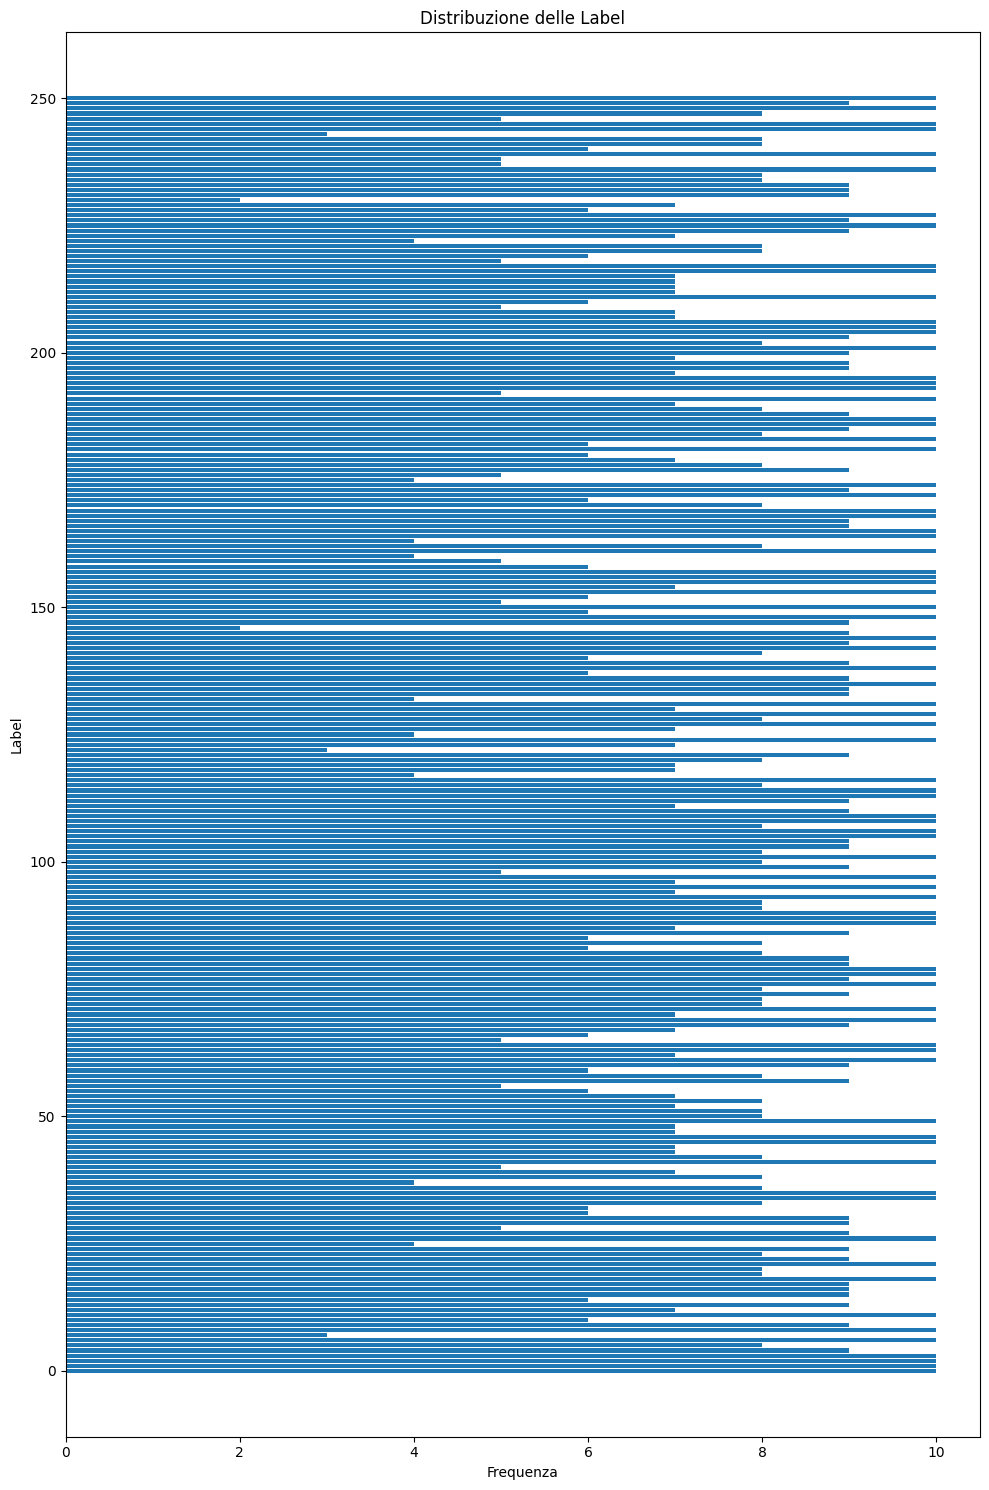

In [149]:
plt.figure(figsize=(10, 15))
label_counts = df_plot['Label'].value_counts()
plt.barh(label_counts.index, label_counts.values)
plt.xlabel('Frequenza')
plt.ylabel('Label')
plt.title('Distribuzione delle Label')
plt.tight_layout()
plt.show()

## Retrieval for single class

In [165]:
indici_m = df_unlabelled.index[df_unlabelled["Label"] == -1].tolist()
feat_unlabelled_current = feat_unlabelled[indici_m]

In [154]:
def get_top_k_neighbours(unlabeled_features, image_features, k=10, metric='cosine'):
    neigh = NearestNeighbors(n_neighbors=k, metric=metric)
    neigh.fit(unlabeled_features)
    _, indices = neigh.kneighbors([image_features])
    return indices[0]

In [161]:
get_top_k_neighbours(feat_unlabelled, centroid, k=10, metric='cosine')

array([ 80, 349, 298, 560, 302,  50, 464, 558, 406,  35], dtype=int64)

In [167]:
indices_top_k_current = get_top_k_neighbours(feat_unlabelled_current, centroid, k=10, metric='cosine')

In [173]:
indices_unlabelled = [indici_m[i] for i in indices_top_k_current]
indices_unlabelled

[91, 175, 544, 422, 159, 545, 546, 183, 299, 514]

## Test retrieval Centroids

In [8]:
retrieval = CentroidRetrieval(df_small, feat_small, df_unlabeled, feat_unlabeled, k=25, metric='cosine')

In [9]:
retrieval.retrieve_images()

100%|██████████| 251/251 [01:17<00:00,  3.25it/s]


In [10]:
retrieval.save_results()

## Test retrieval ClosestToLabelSetRetrieval

In [9]:
retrieval = ClosestToLabelSetRetrieval(df_small, feat_small, df_unlabeled, feat_unlabeled, k=10, metric='cosine')

In [5]:
retrieval.retrieve_images()

113455it [00:02, 51645.65it/s]
113455it [00:02, 54598.48it/s]


array([-1, 21, 21, ..., -1, -1, -1])

In [6]:
retrieval.save_results()